<a href="https://colab.research.google.com/github/MojiDZ/timeSeriesForcastingTimesFM/blob/main/TimesFM_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IMPORTING LIBRARIES


In [1]:
!pip install ipynb
!pip install nbformat
!pip install utilsforecast
!pip install prophet
!pip install pandas numpy seaborn matplotlib scikit-learn catboost
!pip install timesfm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 3.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of googleapis-common-protos to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of transformers to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7

In [2]:
import pandas as pd
import numpy as np
import timesfm as tsfm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# PART 1: Data Loading and Preprocessing


In [26]:
folder_path = '/content/drive/MyDrive/CMAPSSData/'  # Update with your actual path
df_train = pd.read_csv(folder_path + 'train_FD001.txt', header=None, sep=' ')
df_test = pd.read_csv(folder_path + 'test_FD001.txt', header=None, sep=' ')
rul_test = pd.read_csv(folder_path + 'RUL_FD001.txt', header=None)

# Column names
col_names = ['unit', 'time'] + ['os'+str(i) for i in range(1,4)] + ['s'+str(i) for i in range(1,22)]
df_train = df_train.iloc[:, :-2].copy()
df_train.columns = col_names
df_test = df_test.iloc[:, :-2].copy()
df_test.columns = col_names

# Attach RUL values
def attach_rul(df, rul_df=None):
    rul_list = []
    for n in np.arange(1, 101):
        time_list = np.array(df[df['unit'] == n]['time'])
        length = len(time_list)
        if rul_df is not None:  # For test set
            rul_val = rul_df.iloc[n-1].item()
            rul = list(length - time_list + rul_val)
        else:  # For train set
            rul = list(length - time_list)
        rul_list += rul
    df['rul'] = rul_list
    return df

df_train = attach_rul(df_train)
df_test = attach_rul(df_test, rul_test)

# Dropping constant columns
drop_cols = ['os3', 's1', 's5', 's6', 's10', 's16', 's18', 's19']
df_train = df_train.drop(drop_cols, axis=1)
df_test = df_test.drop(drop_cols, axis=1)

# Min-Max Scaling
def minmax_scale(df, minmax_dict=None):
    if minmax_dict is None:
        minmax_dict = {}
        for c in df.columns:
            if 's' in c:
                minmax_dict[c + 'min'] = df[c].min()
                minmax_dict[c + 'max'] = df[c].max()

    for c in df.columns:
        if 's' in c:
            df[c] = (df[c] - minmax_dict[c + 'min']) / (minmax_dict[c + 'max'] - minmax_dict[c + 'min'])
    return df, minmax_dict

df_train, minmax_dict = minmax_scale(df_train)
df_test, _ = minmax_scale(df_test, minmax_dict)  # Use training set's min-max values

# Exponential Weighted Average Smoothing
def smooth(s, b=0.98):
    v = np.zeros(len(s) + 1)
    bc = np.zeros(len(s) + 1)
    for i in range(1, len(v)):
        v[i] = (b * v[i - 1] + (1 - b) * s[i - 1])
        bc[i] = 1 - b**i
    sm = v[1:] / bc[1:]
    return sm

for c in df_train.columns:
    if 's' in c:
        for n in np.arange(1, 101):
            df_train.loc[df_train['unit'] == n, c] = smooth(df_train[df_train['unit'] == n][c].values)

for c in df_test.columns:
    if 's' in c:
        for n in np.arange(1, 101):
            df_test.loc[df_test['unit'] == n, c] = smooth(df_test[df_test['unit'] == n][c].values)


# PART 2: TimesFM Data Preparation


In [27]:
context_len = 256  # Adjust as needed
horizon_len = 16   # Adjust as needed

sensor_to_predict = 's2'  # Choose the sensor you want to predict

def prepare_data_for_timesfm_sensor(df, context_len, horizon_len, sensor_name):
    data = []
    for unit_id in df['unit'].unique():
        unit_data = df[df['unit'] == unit_id].sort_values('time')
        for i in range(len(unit_data) - context_len - horizon_len + 1):
            context_start = i
            context_end = context_start + context_len
            horizon_start = context_end
            horizon_end = horizon_start + horizon_len

            context = unit_data.iloc[context_start:context_end][sensor_name].values  # Only the sensor data
            horizon = unit_data.iloc[horizon_start:horizon_end][sensor_name].values  # Only the sensor data

            data.append((context, horizon))
    return data

train_data = prepare_data_for_timesfm_sensor(df_train, context_len, horizon_len, sensor_to_predict)
test_data = prepare_data_for_timesfm_sensor(df_test, context_len, horizon_len, sensor_to_predict)

frequency = 0  # Adjust based on your engine cycle time granularity


# PART 3: TimesFM Model Initialization

In [28]:
# PART 3: TimesFM Model Initialization
# --- Model Initialization and Loading ---
backend = "cpu"  # Choose "cpu", "gpu", or "tpu"

tfm = tsfm.TimesFm(
    context_len=context_len,
    horizon_len=horizon_len,
    input_patch_len=32,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend=backend,
)

Multiprocessing context has already been set.


# MODEL LOADING

In [29]:
tfm.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Constructing model weights.


Constructed model weights in 6.39 seconds.
Restoring checkpoint from /root/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 1.95 seconds.
Jitting decoding.
Jitted decoding in 35.47 seconds.


# Prediction


In [30]:
# Select an example context for prediction
example_context = train_data[0][0]

point_forecast, experimental_quantile_forecast = tfm.forecast(
    [example_context],  # Input must be a list
    freq=[frequency]
)

# EVALUATION


In [31]:
true_horizon = train_data[0][1]  # Get the horizon for the same example

# Evaluation
rmse = mean_squared_error(true_horizon, point_forecast[0], squared=False)
mae = mean_absolute_error(true_horizon, point_forecast[0])

def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def me(y_true, y_pred):
    return np.mean(y_pred - y_true)

smape_value = smape(true_horizon, point_forecast[0])
me_value = me(true_horizon, point_forecast[0])
mse = mean_squared_error(true_horizon, point_forecast[0])

print(f"RMSE for sensor '{sensor_to_predict}': {rmse:.4f}")
print(f"MAE for sensor '{sensor_to_predict}': {mae:.4f}")
print(f"MSE for sensor '{sensor_to_predict}': {mse:.4f}")
print(f"SMAPE for sensor '{sensor_to_predict}': {smape_value:.4f}")
print(f"ME for sensor '{sensor_to_predict}': {me_value:.4f}")


RMSE for sensor 's2': 0.0045
MAE for sensor 's2': 0.0039
MSE for sensor 's2': 0.0000
SMAPE for sensor 's2': 0.8212
ME for sensor 's2': 0.0039


# VISUALIZING

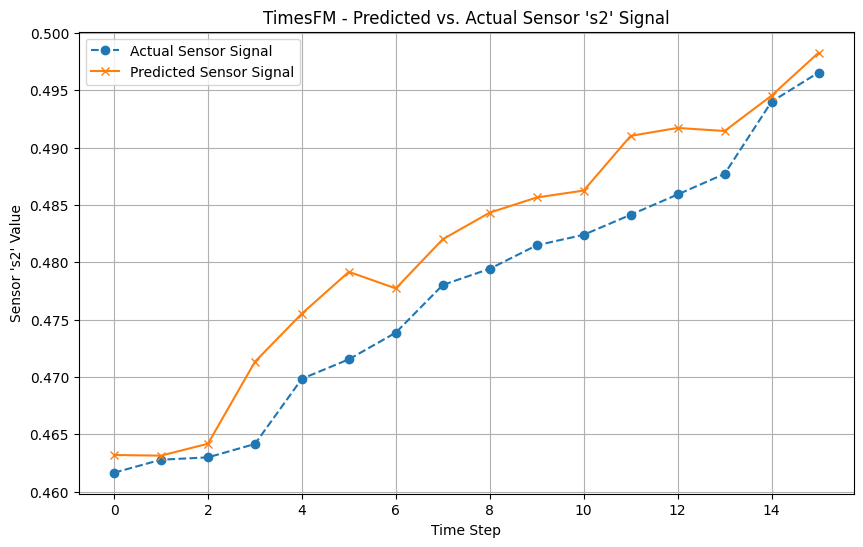

In [32]:
# Plot Predicted vs. Actual sensor signal
plt.figure(figsize=(10, 6))
plt.plot(true_horizon, label="Actual Sensor Signal", linestyle='--', marker='o')
plt.plot(point_forecast[0], label="Predicted Sensor Signal", linestyle='-', marker='x')
plt.xlabel("Time Step")
plt.ylabel(f"Sensor '{sensor_to_predict}' Value")
plt.title(f"TimesFM - Predicted vs. Actual Sensor '{sensor_to_predict}' Signal")
plt.legend()
plt.grid(True)
plt.show()